# Assignment 2 - Recurrent Neural Networks



## Programming (Full points: 100)

In this assignment, our goal is to use PyTorch to implement Recurrent Neural Networks (RNN) for sentiment analysis task. Sentiment analysis is to classify sentences (input) into certain sentiments (output labels), which includes positive, negative and neutral.

We will use a benckmark dataset, SST, for this assignment.
* we download the SST dataset from torchtext package, and do some preprocessing to build vocabulary and split the dataset into training/validation/test sets. You don't need to modify the code in this step.


In [1]:
import copy
import torch
from torch import nn
from torch import optim
import torchtext
from torchtext import data
from torchtext import datasets
import nltk
import matplotlib.pyplot as plt
import numpy as np

TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.LabelField()

# load data splits
train_data, val_data, test_data = datasets.SST.splits(TEXT, LABEL)

# build dictionary
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

# hyperparameters
vocab_size = len(TEXT.vocab)
label_size = len(LABEL.vocab)
padding_idx = TEXT.vocab.stoi['<pad>']
embedding_dim = 128
hidden_dim = 128

# build iterators
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data), 
    batch_size=32)

* define the training and evaluation function in the cell below.
### (25 points)


In [2]:
def train_RNN(network, training_optimizer, epoch_count=5, training_criterion=nn.CrossEntropyLoss(), cuda=False):
    epoch_training_loss = []
    epoch_training_accuracy = []
    epoch_validation_loss = []
    epoch_validation_accuracy = []
    #optimizer = training_optimizer(network.parameters(), lr=0.001)

    for epoch in range(epoch_count):  # loop over the dataset multiple times
        running_loss = 0.0
        total_loss = 0.0
        total = 0
        correct = 0

        for i, data in enumerate(train_iter, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            training_optimizer.zero_grad()

            # forward + backward + optimize
            if cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = network(inputs)
            loss = training_criterion(outputs, labels)
            loss.backward()
            training_optimizer.step()

            # calc training accuracy and loss
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # print statistics
            running_loss += loss.item()
            if i % 40 == 39:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}')
                running_loss = 0.0

        print(f'[{epoch + 1}] training accuracy: {correct / total * 100:.2f}')
                    
        epoch_training_loss.append(total_loss / total)
        epoch_training_accuracy.append(correct / total)

        with torch.no_grad():
            total_loss = 0.0
            total = 0
            correct = 0
            for data in val_iter:
                inputs, labels = data

                if cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                # calculate outputs by running images through the network
                outputs = network(inputs)
                loss = training_criterion(outputs, labels)

                total_loss += loss.item()
                
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'[{epoch + 1}] validation accuracy: {correct / total * 100:.2f}')

        epoch_validation_loss.append(total_loss / total)
        epoch_validation_accuracy.append(correct / total)
        

    print('Finished Training')
    return (epoch_training_accuracy, epoch_training_loss, epoch_validation_accuracy, epoch_validation_loss)

def evaluate_RNN(network, cuda=False):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_iter:
            inputs, labels = data
            if cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = network(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Testing Accuracy: {correct / total}')


In [3]:
def compare_training_to_validation(training_accuracies, validation_accuracies):
    fig, ax = plt.subplots()
    ax.scatter(range(1, len(training_accuracies)+1), training_accuracies, c='blue', label='Training Accuracy')
    ax.scatter(range(1, len(validation_accuracies)+1), validation_accuracies, c='red', label='Validation Accuracy')

    z = np.polyfit(range(1, len(training_accuracies)+1), training_accuracies, 1)
    p = np.poly1d(z)
    plt.plot(range(1, len(training_accuracies)+1), p(range(1, len(training_accuracies)+1)))
    z = np.polyfit(range(1, len(training_accuracies)+1), validation_accuracies, 1)
    p = np.poly1d(z)
    plt.plot(range(1, len(training_accuracies)+1), p(range(1, len(training_accuracies)+1)))

    ax.legend()
    ax.grid(True)

    plt.show()

def compare_hyperparameters(list_of_accuracies, list_of_hyperparameters):
    fig, ax = plt.subplots()
    colors_listing = ['blue', 'red', 'orange', 'green', 'purple']
    for accuracy_idx, accuracy_data in enumerate(list_of_accuracies):
        ax.scatter(range(1, len(accuracy_data)+1), accuracy_data, c=colors_listing[accuracy_idx], label=list_of_hyperparameters[accuracy_idx])

    ax.legend()
    ax.grid(True)

    plt.show()

* build a RNN model for sentiment analysis in the cell below.
We have provided several hyperparameters we needed for building the model, including vocabulary size (vocab_size), the word embedding dimension (embedding_dim), the hidden layer dimension (hidden_dim), the number of layers (num_layers) and the number of sentence labels (label_size). Please fill in the missing codes, and implement a RNN model.
### (40 points)

In [4]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, label_size, num_layers, padding_idx, dropout_rate=0, use_cuda=False):
        super(RNNClassifier, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.label_size = label_size
        self.num_layers = num_layers
        self.use_cuda = use_cuda
        self.dropout_rate = dropout_rate

        # add the layers required for sentiment analysis.
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=padding_idx)
        if num_layers > 1:
            self.rnn = nn.RNN(self.embedding_dim, self.hidden_dim, num_layers=self.num_layers, batch_first=True, dropout=dropout_rate)
        else:
            self.rnn = nn.RNN(self.embedding_dim, self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.label_size)
        self.dropout = nn.Dropout(p=dropout_rate)

    def zero_state(self, batch_size): 
        # implement the function, which returns an initial hidden state.
        zero_state_tensor = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        if self.use_cuda:
            zero_state_tensor = zero_state_tensor.cuda()
        return zero_state_tensor

    def forward(self, text):
        # implement the forward function of the model.
        embedding = self.embedding(text)
        h_0 = self.zero_state(text.shape[0])
        x, h = self.rnn(embedding, h_0)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        # BTW I'm doing this because the shape of x varies between batches for some reason
        linear = nn.Linear(x.shape[1], self.label_size)
        if self.use_cuda:
            linear = linear.cuda()
        x = linear(x)

        h = self.dropout(h[-1, :, :])
        h = self.linear(h)
        return h

* train the model and compute the accuracy in the cell below.
### (20 points)

In [5]:
STT_network = RNNClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    label_size=label_size,
    num_layers=1,
    padding_idx=padding_idx,
)

optimizer = optim.SGD(STT_network.parameters(), lr=0.001, momentum=0.9)

train_RNN(STT_network, optimizer)
evaluate_RNN(STT_network)

[1,    40] loss: 1.076
[1,    80] loss: 1.061
[1,   120] loss: 1.049
[1,   160] loss: 1.055
[1,   200] loss: 1.052
[1,   240] loss: 1.056
[1] training accuracy: 41.74
[1] validation accuracy: 49.32
[2,    40] loss: 1.063
[2,    80] loss: 1.036
[2,   120] loss: 1.041
[2,   160] loss: 1.052
[2,   200] loss: 1.045
[2,   240] loss: 1.045
[2] training accuracy: 42.03
[2] validation accuracy: 46.68
[3,    40] loss: 1.053
[3,    80] loss: 1.052
[3,   120] loss: 1.046
[3,   160] loss: 1.048
[3,   200] loss: 1.041
[3,   240] loss: 1.048
[3] training accuracy: 42.13
[3] validation accuracy: 46.96
[4,    40] loss: 1.050
[4,    80] loss: 1.034
[4,   120] loss: 1.046
[4,   160] loss: 1.043
[4,   200] loss: 1.041
[4,   240] loss: 1.058
[4] training accuracy: 42.13
[4] validation accuracy: 46.05
[5,    40] loss: 1.045
[5,    80] loss: 1.057
[5,   120] loss: 1.045
[5,   160] loss: 1.031
[5,   200] loss: 1.057
[5,   240] loss: 1.047
[5] training accuracy: 42.29
[5] validation accuracy: 41.60
Finished T

* try to train a model with better accuracy in the cell below. For example, you can use different optimizers such as SGD and Adam. You can also compare different hyperparameters and model size.
### (15 points), to obtain FULL point in this problem, the accuracy needs to be higher than 70%

RNNClassifier(
  (embedding): Embedding(16583, 512, padding_idx=1)
  (rnn): RNN(512, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
[1,    40] loss: 1.072
[1,    80] loss: 1.060
[1,   120] loss: 1.040
[1,   160] loss: 1.037
[1,   200] loss: 1.054
[1,   240] loss: 1.061
[1] training accuracy: 41.43
[1] validation accuracy: 40.87
[2,    40] loss: 1.026
[2,    80] loss: 1.046
[2,   120] loss: 1.064
[2,   160] loss: 1.050
[2,   200] loss: 1.050
[2,   240] loss: 1.044
[2] training accuracy: 41.73
[2] validation accuracy: 43.23
[3,    40] loss: 1.054
[3,    80] loss: 1.047
[3,   120] loss: 1.051
[3,   160] loss: 1.049
[3,   200] loss: 1.041
[3,   240] loss: 1.043
[3] training accuracy: 42.31
[3] validation accuracy: 39.06
[4,    40] loss: 1.042
[4,    80] loss: 1.050
[4,   120] loss: 1.046
[4,   160] loss: 1.044
[4,   200] loss: 1.044
[4,   240] loss: 1.037
[4] training accuracy: 41.74
[4] validation accuracy

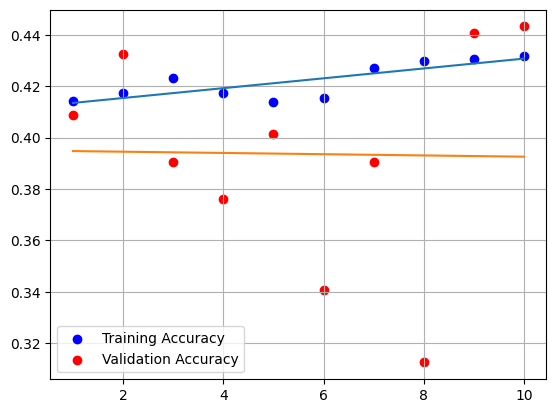

Testing Accuracy: 0.4447963800904977


In [6]:
#Experimentation Block

num_layers = 1
num_epochs = 10
embedding_dim = 512
hidden_dim = 256
learning_rate = 0.0001
momentum = 0.9
dropout_rate = 0.2

SST_network = RNNClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    label_size=label_size,
    num_layers=num_layers,
    padding_idx=padding_idx,
    use_cuda=True,
    dropout_rate=dropout_rate,
).cuda()

print(SST_network)

adam_optimizer = optim.Adam(SST_network.parameters(), lr=learning_rate)
sgd_optimizer = optim.SGD(SST_network.parameters(), lr=learning_rate, momentum=momentum)

(t_acc, t_loss, v_acc, v_loss) = train_RNN(SST_network, adam_optimizer, epoch_count=num_epochs, training_criterion=nn.CrossEntropyLoss(), cuda=True)
compare_training_to_validation(t_acc, v_acc)
evaluate_RNN(SST_network, cuda=True)

Results: Embedding_dim, Hidden_dim, and num_layers have varying levels of success, but produce results with stagnant trends for the most part. Dropout rate helped increase accuracy, and 0.5 was found to be the best. For some reason, using the hidden layer of the RNN as the output produced results around a flat 10% higher in accuracy across all tests.